In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Import Libraries

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision import datasets, transforms
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.utils import make_grid
from PIL import Image,ImageFile
from sklearn.model_selection import train_test_split
from torch.utils.data import SubsetRandomSampler, WeightedRandomSampler
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchvision.utils



In [ ]:
#
ImageFile.LOAD_TRUNCATED_IMAGES = True


Load Images and preprocess

In [3]:
#Load images and dataset.csv file
dataset_root = "/content/drive/MyDrive/Colab Notebooks/Images"
csv_path = "/content/drive/MyDrive/dataset_labels.csv"

In [4]:
#Extract image and label from the
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(self.data['label'].unique())
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        self.data['label_idx'] = self.data['label'].map(self.class_to_idx)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        filename = self.data.iloc[idx, 0]
        label = self.data.iloc[idx, 2]  # Use precomputed numeric label

        img_path = os.path.join(self.root_dir, self.data.iloc[idx, 1], filename)

        try:
            image = Image.open(img_path).convert("RGB")  # Open image
        except (OSError, IOError):
            print(f"Skipping corrupted image: {img_path}")
            return self.__getitem__((idx + 1) % len(self))  # Load next image instead

        if self.transform:
            image = self.transform(image)

        return image, label


In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for ResNet50
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ResNet standard normalization

])


In [6]:
df = pd.read_csv(csv_path)
class_counts = df['label'].value_counts().sort_index()
class_weights = 1.0 / torch.tensor(class_counts.values, dtype=torch.float32)
df['label_idx'] = df['label'].astype('category').cat.codes  # Convert labels to indices

# Load Dataset

dataset = CustomDataset(csv_path, dataset_root, transform=transform)


# Split Dataset (70% Train, 20% Val, 10% Test)

train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


# Use Weighted Random Sampler for Train Set

labels = df.iloc[train_dataset.indices]['label_idx'].values  # Get labels from train indices
samples_weights = [class_weights[label] for label in labels]
train_sampler = WeightedRandomSampler(samples_weights, num_samples=len(samples_weights), replacement=True)


# Create DataLoaders (Use num_workers > 0 for Faster Loading)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

print(f"Train: {len(train_loader.dataset)}, Val: {len(val_loader.dataset)}, Test: {len(test_loader.dataset)}")

Train: 11077, Val: 3165, Test: 1583


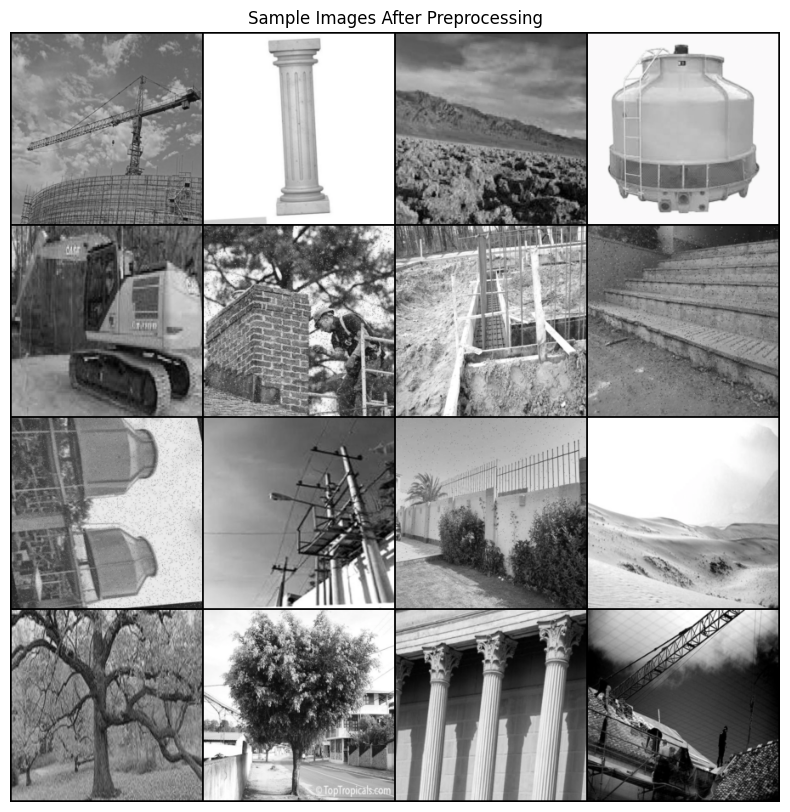

In [7]:
#Visualize the sample images after preprocessing
def show_images(loader):
    images, labels = next(iter(loader))
    images = images[:16]  # Show first 16 images
    labels = labels[:16]

    # Unnormalize images
    images = images * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)

    grid_img = torchvision.utils.make_grid(images, nrow=4)
    plt.figure(figsize=(10,10))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.title("Sample Images After Preprocessing")
    plt.axis("off")
    plt.show()

show_images(train_loader)

In [8]:
#Check if CUDA is enabled
import torch
print("CUDA Available:", torch.cuda.is_available())


CUDA Available: False


Model Training

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load pretrained EfficientNet-B0
model = models.efficientnet_b0(pretrained=True)
num_ftrs = model.classifier[1].in_features  # Get last layer input features
model.classifier[1] = nn.Linear(num_ftrs, len(class_counts))  # Modify last layer

model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 36.8MB/s]


In [10]:
model.classifier[1] = nn.Sequential(
    nn.Dropout(0.4),  # Add dropout before final layer
    nn.Linear(num_ftrs, len(class_counts))
)

In [11]:
import torch.optim as optim

# Define class-weighted loss function
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

# Define optimizer & weight decay for regularization
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

# Define learning rate scheduler (reduce LR every 10 epochs)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move model to GPU

for images, labels in train_loader:
    images = images.to(device)  # Move images to GPU
    labels = labels.to(device)  # Move labels to GPU


In [13]:
def evaluate_model(model, dataloader):
    model.eval()
    total, correct = 0, 0
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)  # Move to GPU
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return val_loss / len(dataloader), correct / total


In [ ]:
from tqdm import tqdm

num_epochs = 5
scaler = torch.amp.GradScaler()  # Mixed precision training
best_val_loss = float("inf")
patience = 5
wait = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with torch.amp.autocast("cuda"):  # Mixed precision
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        progress_bar.set_postfix({"Batch Loss": loss.item()})

    train_accuracy = correct / total
    val_loss, val_accuracy = evaluate_model(model, val_loader)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {running_loss/len(train_loader):.4f} | Train Acc: {train_accuracy:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.4f}")

    scheduler.step()

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")  # Save best model
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early Stopping Triggered!")
            break


/usr/local/lib/python3.11/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
Epoch 1/5:   0%|          | 0/347 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
Epoch 1/5: 100%|██████████| 347/347 [52:35<00:00,  9.09s/it, Batch Loss=0.216]


Skipping corrupted image: /content/drive/MyDrive/Colab Notebooks/Images/Residential/Residential_image170.jpg
Epoch 1/5 | Train Loss: 0.8960 | Train Acc: 0.8029 | Val Loss: 0.1223 | Val Acc: 0.9719


Epoch 2/5:  37%|███▋      | 129/347 [19:07<31:25,  8.65s/it, Batch Loss=0.204]

Model Evaluation and Testing

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Evaluate model on test data
def evaluate_model_on_test(model, test_loader, class_names):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    print(f"Accuracy: {accuracy_score(y_true, y_pred) * 100:.2f}%")

    return y_true, y_pred

# Call evaluation function
dataset = "/content/drive/MyDrive/Colab Notebooks/Images/"
class_names = sorted(os.listdir(dataset))
y_true, y_pred = evaluate_model_on_test(model, test_loader, class_names)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from sklearn.metrics import precision_recall_curve

# Compute Precision-Recall Curve
y_scores = []
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        y_scores.extend(probs.cpu().numpy())

y_scores = np.array(y_scores)

# Plot Precision-Recall Curve for each class
plt.figure(figsize=(8, 6))
for i, class_name in enumerate(class_names):
    precision, recall, _ = precision_recall_curve(np.array(y_true) == i, y_scores[:, i])
    plt.plot(recall, precision, label=f"{class_name}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score

# Convert `y_scores` from probabilities to class predictions
y_pred = y_scores.argmax(axis=1)

# Compute macro precision and recall
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')

print(f"Macro Precision: {precision_macro:.4f}")
print(f"Macro Recall: {recall_macro:.4f}")


In [ ]:
from sklearn.metrics import precision_score, recall_score

# Convert probabilities to class predictions
y_pred = y_scores.argmax(axis=1)

# Compute precision and recall for each class
precision_per_class = precision_score(y_true, y_pred, average=None)
recall_per_class = recall_score(y_true, y_pred, average=None)

# Define your original class names in the correct order
class_names = ["Boundary Wall", "Chimney", "Concrete Column", "Concrete Footing",
               "Construction Worker", "Earth Mover", "Electric Generator",
               "Excavated Pit", "Land", "Power Lines", "Residential",
               "Solar Panel", "Staircase", "Tower Crane", "Tree", "Water Tank"]

# Print values with class names
print("\nPrecision & Recall for Each Class:\n")
for name, prec, rec in zip(class_names, precision_per_class, recall_per_class):
    print(f"{name}: Precision = {prec:.4f}, Recall = {rec:.4f}")


In [ ]:
import random

def show_predictions(model, test_loader, class_names, num_images=5):
    model.eval()
    images_seen = 0
    plt.figure(figsize=(12, 8))

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(len(images)):
                if images_seen >= num_images:
                    return
                images_seen += 1

                plt.subplot(1, num_images, images_seen)
                plt.imshow(images[i].cpu().permute(1, 2, 0))  # Convert tensor to image
                plt.title(f"Pred: {class_names[preds[i]]}\nActual: {class_names[labels[i]]}",
                          color=("green" if preds[i] == labels[i] else "red"))
                plt.axis("off")

# Show correct & incorrect predictions
show_predictions(model, test_loader, class_names)
